# Experiments Variational Repersentation


In [1]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

import numpy as np
from scipy.stats import norm
from sklearn.datasets import make_moons, make_circles

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

## Model implementation

In [3]:
def get_simple_model(hiddens, activation=nn.ReLU()):
    assert len(hiddens) > 1
    modules = []
    for i, (in_, out_) in enumerate(zip(hiddens[:-1], hiddens[1:])):
        modules.extend([nn.Linear(in_, out_), activation])
    return nn.Sequential(*modules)

In [4]:
# Define of divergence's conjugate function
class Conjugate(nn.Module):
    conjugates = {
        'forward_kl': lambda x: torch.exp(x - 1),
        'reverse_kl': lambda x: -1 - torch.log(-x),
        'js': lambda x: -torch.log(1 - torch.exp(x))
    }
    
    def __init__(self, divergence='forward_kl'):
        super().__init__()
        assert divergence in self.conjugates.keys() 
        self.conjugate = self.conjugates[divergence]

    def forward(self, x):
        return self.conjugate(x)

# Define of divergence's activation function
class Activation(nn.Module):
    activations = {
        'forward_kl': lambda x: x,
        'reverse_kl': lambda x: -torch.exp(-x),
        'js': lambda x: -torch.log(1 + torch.exp(-x))
    }
    
    def __init__(self, divergence='forward_kl'):
        super().__init__()
        assert divergence in self.activations.keys() 
        self.activation = self.activations[divergence]

    def forward(self, x):
        return self.activation(x)

In [42]:
class Conditional(nn.Module):
    def __init__(self, in_dim, gamma=None):
        super().__init__()
        
        self.in_dim = in_dim
        self.net =  get_simple_model([in_dim, 256, 256]) # , nn.ELU())
        self.last = nn.Linear(256, 2 * in_dim)
        
        if gamma is not None:
            for module in self.net:
                self._init_weights_net(module)
            self._init_weights_net(self.last)
            self._init_weights_gamma(self.last, torch.tensor(gamma))       

    def forward(self, y):
        mu, log_std = self.last(self.net(y)).chunk(2, dim=1)
        return torch.exp(log_std) * self._prior(mu.shape) + mu

    def _prior(self, size):
        return Normal(.0, 1.).sample(size)

    def log_prob(self, x, y):
        mu, log_std = self.last(self.net(y)).chunk(2, dim=1)
        return Normal(mu, torch.exp(log_std)).log_prob(x)

    def _init_weights_net(self, module):
        if isinstance(module, nn.Linear):
            nn.init.eye_(module.weight)
            nn.init.zeros_(module.bias)
            
    def _init_weights_gamma(self, module, gamma):
        if isinstance(module, nn.Linear):
            module.bias.data[len(module.bias) // 2:].fill_(torch.log(gamma))
    
############## TEST ##################
test_in_dim = 2
test_latent_dim = 2
test_cond = Conditional(test_in_dim, 100)

test_x = torch.ones((2, test_in_dim))
test_cond(test_x)
test_cond

Conditional(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (last): Linear(in_features=256, out_features=4, bias=True)
)

In [43]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, divergence='forward_kl'):
        super().__init__()
        self.in_dim = in_dim

        self.net = get_simple_model([2 * in_dim, 256, 256]) #, nn.ELU()) # , nn.LeakyReLU(0.1))
        self.last = nn.Linear(256, 1)
        self.activation = Activation(divergence)
        self.conjugate = Conjugate(divergence)

    def forward(self, x, y, conjugate=False):
        x_y = torch.concat([x, y], dim=1)
        x_y = self.activation(self.last(self.net(x_y)))
        return x_y if not conjugate else self.conjugate(x_y)

############## TEST ##################
test_in_dim = 2
test_disc = Discriminator(test_in_dim)

test_x = torch.rand((4, test_in_dim))
test_y = torch.rand((4, test_in_dim))
test_disc(test_x, test_y)
test_disc

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (last): Linear(in_features=256, out_features=1, bias=True)
  (activation): Activation()
  (conjugate): Conjugate()
)

In [44]:
class AdversarialIPFPTrainer:
    def __init__(self, batch_size, cond_p, cond_q, disc_b, disc_f, lr_gen=None, lr_disc=None):
        self.batch_size = batch_size
        self.dim  = cond_p.in_dim
        
        self.cond_p = cond_p # x|y
        self.cond_q = cond_q # y|x
        self.disc_b = disc_b
        self.disc_f = disc_f

        if lr_gen is None:
            lr_gen = {
                'forward': 1e-4,
                'backward': 1e-4,
            }
        if lr_disc is None:
            lr_disc = {
                'forward': 1e-4,
                'backward': 1e-4,
            }

        self.optim_gen = {
            'forward': torch.optim.Adam(cond_q.parameters(), lr=lr_gen['forward']),
            'backward': torch.optim.Adam(cond_p.parameters(), lr=lr_gen['backward']), #, weight_decay=0.5, betas=(0.5, 0.999))
        } 
        self.optim_disc = {
            'forward': torch.optim.Adam(disc_f.parameters(), lr=lr_disc['forward']),
            'backward': torch.optim.Adam(disc_b.parameters(), lr=lr_disc['backward']), #, weight_decay=0.5, betas=(0.5, 0.999))
        } 
        
    def _backward_step(self, x, y):
        loss_cond = self._train_step_gen(y, self.cond_p, self.disc_b, self.optim_gen, step='backward')
        loss_disc = self._train_step_disc(y, x, self.cond_p, self.cond_q, self.disc_b, self.optim_disc, step='backward')
        return loss_cond, loss_disc

    def _forward_step(self, x, y):
        loss_cond = self._train_step_gen(x, self.cond_q, self.disc_f, self.optim_gen, step='forward')
        loss_disc = self._train_step_disc(x, y, self.cond_q, self.cond_p, self.disc_f, self.optim_disc, step='forward')
        return loss_cond, loss_disc
    
    def _train_step_gen(self, latent, cond, disc, optim, step):
        optim[step].zero_grad()

        # Generate fake samples
        generated = cond(latent)

        if step == 'backward':
            loss = disc(generated, latent).mean()
        else:
            loss = disc(latent, generated).mean()
        
        loss.backward()
        optim[step].step()
        # self.lr_scheduler_gen.step()
        return loss.detach().cpu().item()
    
    def _train_step_disc(self, latent1, latent2, cond, cond_fixed, disc, optim, step):
        optim[step].zero_grad()

        # calc training cond loss
        generated = cond(latent1)

        if step == 'backward':
            loss_training = disc(generated, latent1).mean() # В случае backward в Discriminator подается (y, x)
        else:
            loss_training = disc(latent1, generated).mean()

        # calc fixed cond loss
        with torch.no_grad():
            generated = cond_fixed(latent2)
            
        if step == 'backward':
            loss_fixed = disc(latent2, generated, conjugate=True).mean()
        else:
            loss_fixed = disc(generated, latent2, conjugate=True).mean()
        

        # combine
        loss = loss_fixed - loss_training
        loss.backward()
        optim[step].step()
            
        return -loss.detach().cpu().item()
        
@torch.no_grad()     
def compute_kl_divergence(x, y, cond, cond_fixed, marg, marg_fixed):
    lob_prob_marg = marg.log_prob(x)
    log_prob_cond = cond.log_prob(y, x)
    log_probs = lob_prob_marg + log_prob_cond

    lob_prob_marg_fixed = marg_fixed.log_prob(y)
    log_prob_cond_fixed = cond_fixed.log_prob(x, y)
    log_probs_fixed = lob_prob_marg_fixed + log_prob_cond_fixed
    
    kl_div = torch.exp(log_probs) * (log_probs - log_probs_fixed)
    return kl_div.sum()

Backward:
$$
\mathbb{E}_{y\sim\pi_1(y)}\mathbb{E}_{x\sim p(x|y)}D(x,y) - \mathbb{E}_{x\sim\pi_0(x)}\mathbb{E}_{y\sim q^*(y|x)}e^{D(x,y)-1}
$$

Forward:
$$
\mathbb{E}_{x\sim\pi_0(x)}\mathbb{E}_{y\sim q(y|x)}D(x,y) - \mathbb{E}_{y\sim\pi_1(y)}\mathbb{E}_{x\sim p^*(x|y)}e^{D(x,y)-1}
$$

Algorithm:
1. Sample real $x$, $y$
2. Sample fake $x$, $y$ from conditional pdf $p(x|y)$ and $q(y|x)$
3. Calculate expectation loss

### For onevariate dataset calculate kl div using marginal and conditional

In [45]:
class OneVariateDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.x = Normal(-2, 1).sample([size, 1])
        self.y = Normal(5, 1).sample([size, 1])

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.x[idx], self.y[idx]

In [53]:
# Models parameters
data_dim = 1
divergence='forward_kl'

marginal_x = Normal(-2, 1)
marginal_y = Normal(5, 1)
conditional_p = Conditional(data_dim)
conditional_q = Conditional(data_dim, gamma=30)
discriminator_backward = Discriminator(data_dim, divergence=divergence)
discriminator_forward = Discriminator(data_dim, divergence=divergence)

# Trainer and dataloader parameters
batch_size = 4098

# dataset = OneVariateDataset(60_000)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen={'forward': 1e-4, 'backward': 1e-4},
    lr_disc={'forward': 1e-3, 'backward': 1e-3}
)

losses = {'cond_p': [], 'cond_q': [], 'disc_b': [], 'disc_f': []}

for epoch in range(5000):
    avg_loss_cond_p, avg_loss_cond_q = 0, 0
    avg_loss_disc_b, avg_loss_disc_f = 0, 0

    avg_kl_div_b, avg_kl_div_f = 0, 0
    
    # for batch in dataloader:
    x = marginal_x.sample([batch_size, 1])
    y = marginal_y.sample([batch_size, 1])
    
    loss_cond_p, loss_disc_b = trainer._backward_step(x, y)
    avg_loss_cond_p += loss_cond_p
    avg_loss_disc_b += loss_disc_b
    avg_kl_div_b += compute_kl_divergence(y, x, trainer.cond_p, trainer.cond_q, marginal_y, marginal_x)
        
    loss_cond_q, loss_disc_f = trainer._forward_step(x, y)
    avg_loss_cond_q += loss_cond_q
    avg_loss_disc_f += loss_disc_f
    avg_kl_div_f += compute_kl_divergence(x, y, trainer.cond_q, trainer.cond_p, marginal_x, marginal_y)
    
    losses['cond_p'].append(avg_loss_cond_p / batch_size)
    losses['cond_q'].append(avg_loss_cond_q / batch_size)
    losses['disc_b'].append(avg_loss_disc_b / batch_size)
    losses['disc_f'].append(avg_loss_disc_f / batch_size)

    avg_kl_div_b /= batch_size
    avg_kl_div_f /= batch_size

    if (epoch + 1) % 500 == 0:
        print(f'Iteration: {epoch + 1}; KL(p||q): {avg_kl_div_b}, KL(q||p): {avg_kl_div_f}')
# print(f'Iteration: {epoch + 1}; cond_p: {losses["cond_p"][-1]}, cond_q: {losses["cond_q"][-1]}, disc_f: {losses["disc_f"][-1]}, disc_b: {losses["disc_b"][-1]}')

Iteration: 500; KL(p||q): 0.14781515300273895, KL(q||p): -0.0076876855455338955
Iteration: 1000; KL(p||q): 0.3015083968639374, KL(q||p): -0.011777039617300034
Iteration: 1500; KL(p||q): 0.17260071635246277, KL(q||p): -0.008376934565603733
Iteration: 2000; KL(p||q): 0.21088844537734985, KL(q||p): -0.011763921007514
Iteration: 2500; KL(p||q): 0.2830136716365814, KL(q||p): -0.008203424513339996
Iteration: 3000; KL(p||q): 0.1804857850074768, KL(q||p): -0.013487729243934155
Iteration: 3500; KL(p||q): 0.15272825956344604, KL(q||p): -0.01369006559252739
Iteration: 4000; KL(p||q): 0.16864222288131714, KL(q||p): -0.015099902637302876
Iteration: 4500; KL(p||q): 0.1362476795911789, KL(q||p): -0.01538222935050726
Iteration: 5000; KL(p||q): 0.19971366226673126, KL(q||p): -0.016277989372611046


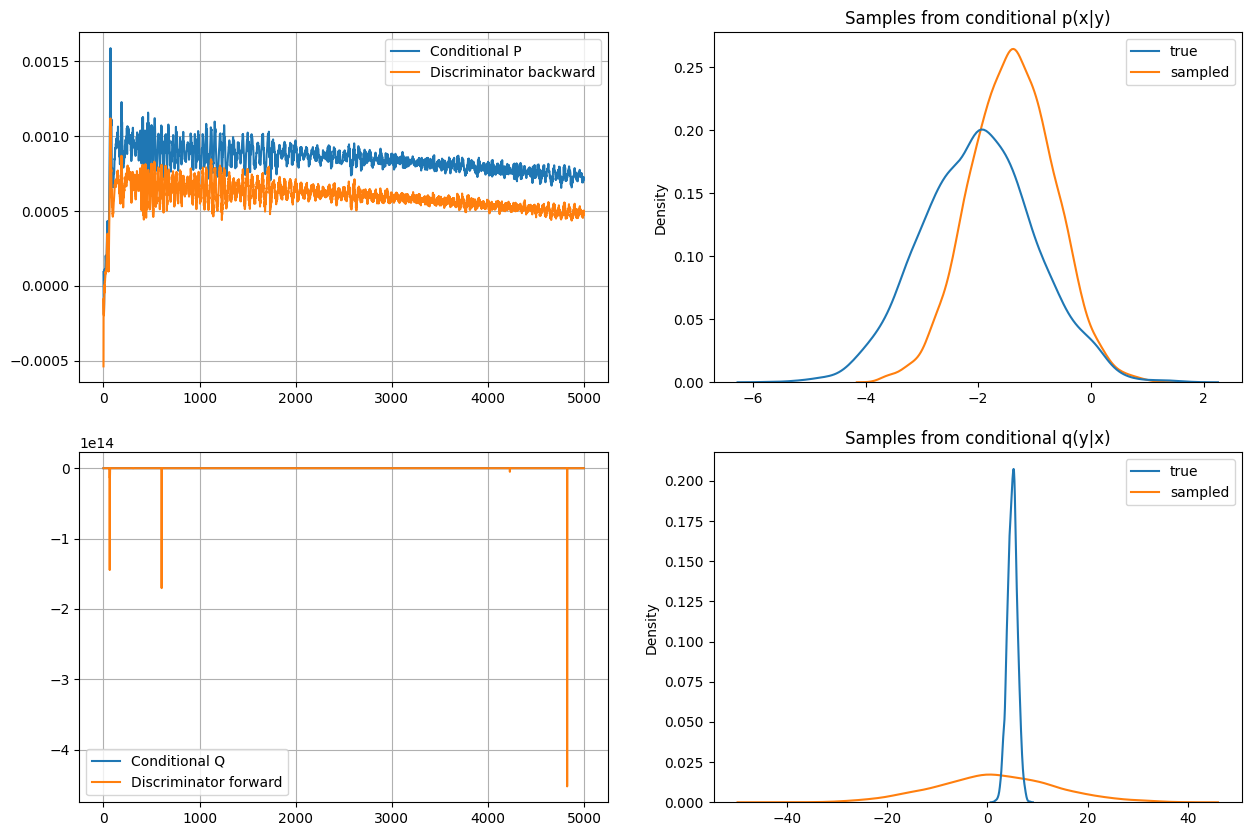

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Plot losses
axs[0][0].plot(losses['cond_p'], label='Conditional P')
axs[0][0].plot(losses['disc_b'], label='Discriminator backward')
axs[0][0].grid()
axs[0][0].legend()

axs[1][0].plot(losses['cond_q'], label='Conditional Q')
axs[1][0].plot(losses['disc_f'], label='Discriminator forward')
axs[1][0].grid()
axs[1][0].legend()

# Plot samples 
n_samples = 4098
true_x = marginal_x.sample([n_samples, 1])
true_y = marginal_y.sample([n_samples, 1])

conditional_q.eval()
sampled_y = conditional_q(true_x).detach().numpy()
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[1][1])
axs[1][1].set_title("Samples from conditional q(y|x)")

conditional_p.eval()
sampled_x = conditional_p(true_y).detach().numpy()
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[0][1])
axs[0][1].set_title("Samples from conditional p(x|y)")

plt.show()

### For twovariate dataset

In [11]:
def visualize(cond_p, cond_q, dataset):
    circles, moons = dataset.circles[:2_000], dataset.moons[:2_000]
    
    fake_circles = pd.DataFrame(cond_p(moons).detach().numpy(), columns=['x', 'y'])
    fake_moons = pd.DataFrame(cond_q(circles).detach().numpy(), columns=['x', 'y'])
    circles = pd.DataFrame(circles, columns=['x', 'y'])
    moons = pd.DataFrame(moons, columns=['x', 'y'])
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 4))
    sns.kdeplot(circles, x='x', y='y', fill=True, ax=axs[0][0])
    axs[0][0].set_title("Circles")
    sns.kdeplot(fake_circles, x='x', y='y', fill=True, color='r', ax=axs[0][1])
    axs[0][1].set_title("Fake Circles")
    sns.kdeplot(moons, x='x', y='y', fill=True, ax=axs[1][0])
    axs[1][0].set_title("Moons")
    sns.kdeplot(fake_moons, x='x', y='y', fill=True, color='r', ax=axs[1][1])
    axs[1][1].set_title("Fake Moons")
    plt.show()

In [12]:
class MoonCircleDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.circles = torch.tensor(make_circles(size, noise=0.05, factor=0.5)[0], dtype=torch.float)
        self.moons = torch.tensor(make_moons(size, noise=0.05)[0], dtype=torch.float)

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.circles[idx], self.moons[idx]

## Training

In [15]:
# Models parameters
data_dim = 2
divergence='forward_kl'

conditional_p = Conditional(data_dim)
conditional_q = Conditional(data_dim, gamma=5)
discriminator_backward = Discriminator(data_dim, divergence=divergence)
discriminator_forward = Discriminator(data_dim, divergence=divergence)


# Trainer and dataloader parameters
batch_size = 4098

dataset = MoonCircleDataset(60_000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen={'forward': 1e-4, 'backward': 1e-4},
    lr_disc={'forward': 1e-3, 'backward': 1e-3}
)

losses = {'cond_p': [], 'cond_q': [], 'disc_b': [], 'disc_f': []}

for epoch in range(1000):
    avg_loss_cond_p, avg_loss_cond_q = 0, 0
    avg_loss_disc_b, avg_loss_disc_f = 0, 0
    
    for batch in dataloader:
        x, y = batch
        
        loss_cond_p, loss_disc_b = trainer._backward_step(x, y)
        avg_loss_cond_p += loss_cond_p
        avg_loss_disc_b += loss_disc_b
            
        loss_cond_q, loss_disc_f = trainer._forward_step(x, y)
        avg_loss_cond_q += loss_cond_q
        avg_loss_disc_f += loss_disc_f
    
    losses['cond_p'].append(avg_loss_cond_p / batch_size)
    losses['cond_q'].append(avg_loss_cond_q / batch_size)
    losses['disc_b'].append(avg_loss_disc_b / batch_size)
    losses['disc_f'].append(avg_loss_disc_f / batch_size)


    if (epoch + 1) % 10 == 0:
        print(f'Iteration: {epoch + 1}; cond_p: {losses["cond_p"][-1]}, cond_q: {losses["cond_q"][-1]}, disc_f: {losses["disc_f"][-1]}, disc_b: {losses["disc_b"][-1]}')

Iteration: 10; cond_p: 0.010062970610116387, cond_q: 0.018070398044911985, disc_f: 0.014276824095238705, disc_b: 0.007416369363469226
Iteration: 20; cond_p: 0.013602745189731908, cond_q: 0.13671594064022752, disc_f: 0.13412392087073488, disc_b: 0.00982222288279722
Iteration: 30; cond_p: 0.013006429197498505, cond_q: 0.3934313903034112, disc_f: 0.38952179662537845, disc_b: 0.009139760230563803
Iteration: 40; cond_p: 0.011865842743813556, cond_q: 0.5885633112105467, disc_f: 0.5808437304592179, disc_b: 0.008131334000881152
Iteration: 50; cond_p: 0.010727045185802156, cond_q: 0.6414462453042548, disc_f: 0.6414170272179264, disc_b: 0.006986490774876086
Iteration: 60; cond_p: 0.009913271493944324, cond_q: 0.6647865664033904, disc_f: 0.6582889622045529, disc_b: 0.006157086150363459
Iteration: 70; cond_p: 0.009082622502477301, cond_q: 0.6404675827659357, disc_f: 0.6330253485646581, disc_b: 0.005316812303253591
Iteration: 80; cond_p: 0.008339371374026922, cond_q: 0.5466219193182554, disc_f: 0.5

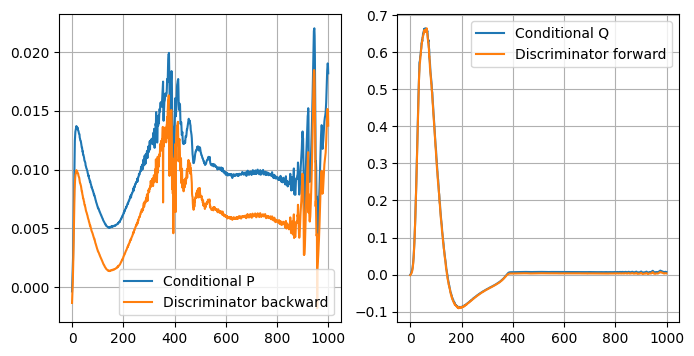

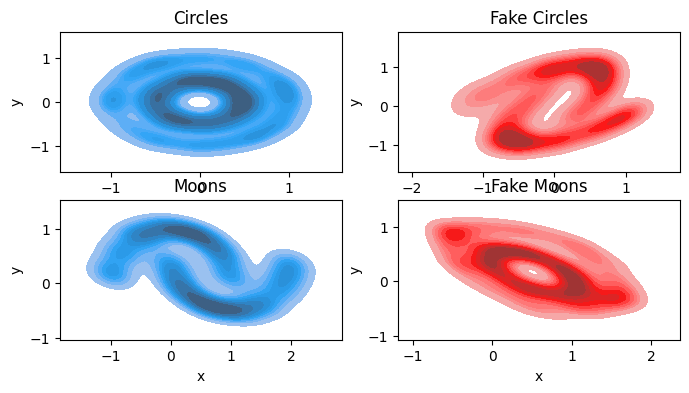

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# Plot losses
axs[0].plot(losses['cond_p'], label='Conditional P')
axs[0].plot(losses['disc_b'], label='Discriminator backward')
axs[0].grid()
axs[0].legend()

axs[1].plot(losses['cond_q'], label='Conditional Q')
axs[1].plot(losses['disc_f'], label='Discriminator forward')
axs[1].grid()
axs[1].legend()

# plt.grid()
# plt.legend()
visualize(conditional_p, conditional_q, dataset)